<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#pip install pmdarima

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


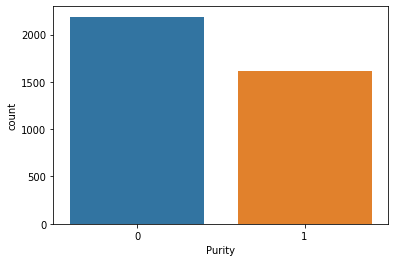

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates')
df.drop('Unnamed: 0', axis=1, inplace=True)

sns.countplot(x ='Purity', data = df)
plt.show()

In [3]:
df_no_idx = df.reset_index()

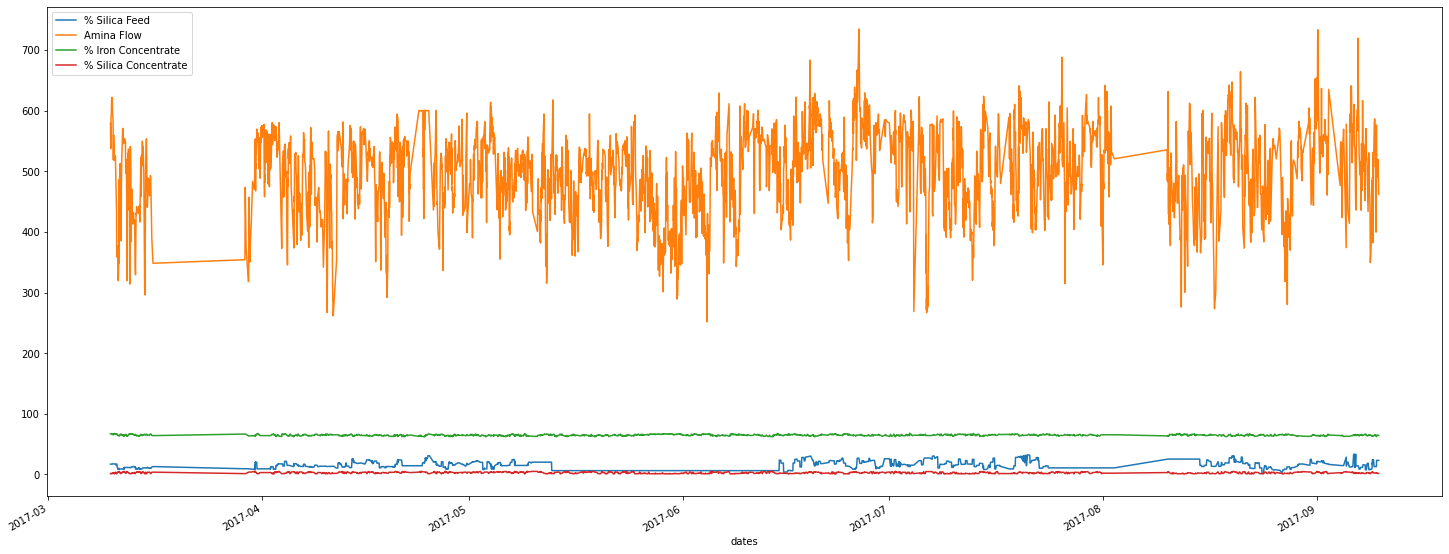

In [4]:
fig, ax = plt.subplots(figsize=(25,10))
df[['% Silica Feed','Amina Flow','% Iron Concentrate','% Silica Concentrate']].plot(ax=ax, x_compat=True)

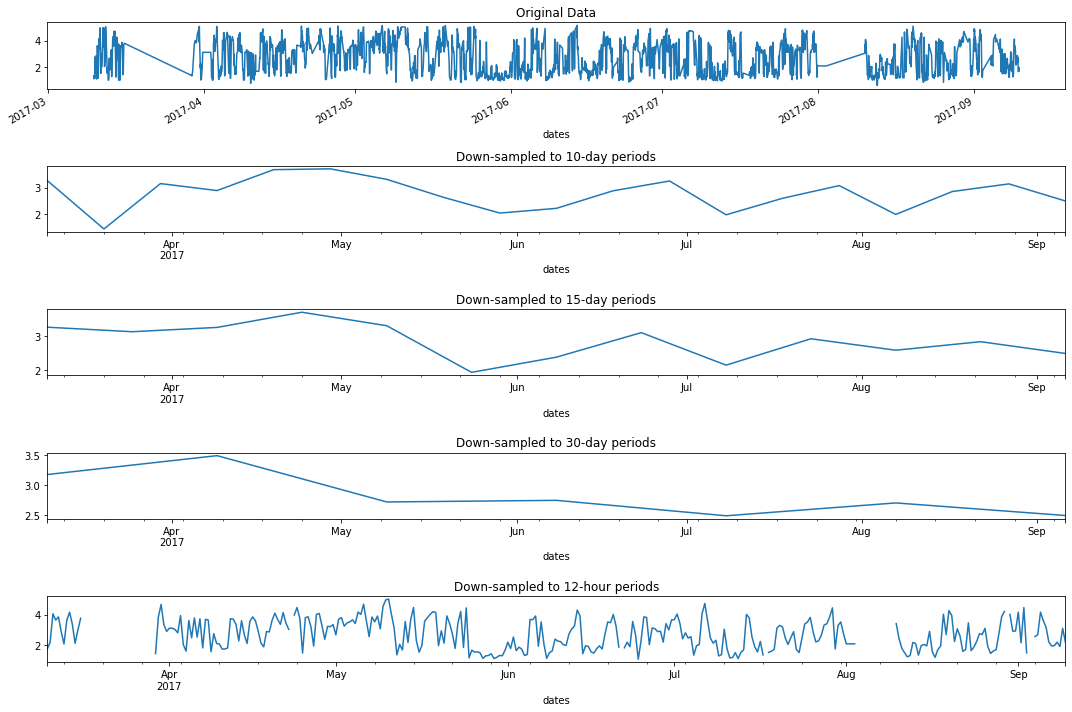

In [5]:
fig, ax = plt.subplots(5, sharex=False)

df["% Silica Concentrate"].plot(figsize=(15,10), ax=ax[0], title="Original Data",
legend=False)
 
df["% Silica Concentrate"].resample('10D').mean().plot(figsize=(15,10), ax=ax[1], 
title="Down-sampled to 10-day periods",legend=False)

df["% Silica Concentrate"].resample('15D').mean().plot(figsize=(15,10), ax=ax[2],
title="Down-sampled to 15-day periods",legend=False)

df["% Silica Concentrate"].resample('30D').mean().plot(figsize=(15,10), ax=ax[3],
title="Down-sampled to 30-day periods",legend=False)

df["% Silica Concentrate"].resample('12H').mean().plot(figsize=(15,10), ax=ax[4], 
title="Down-sampled to 12-hour periods",legend=False)

fig.tight_layout()


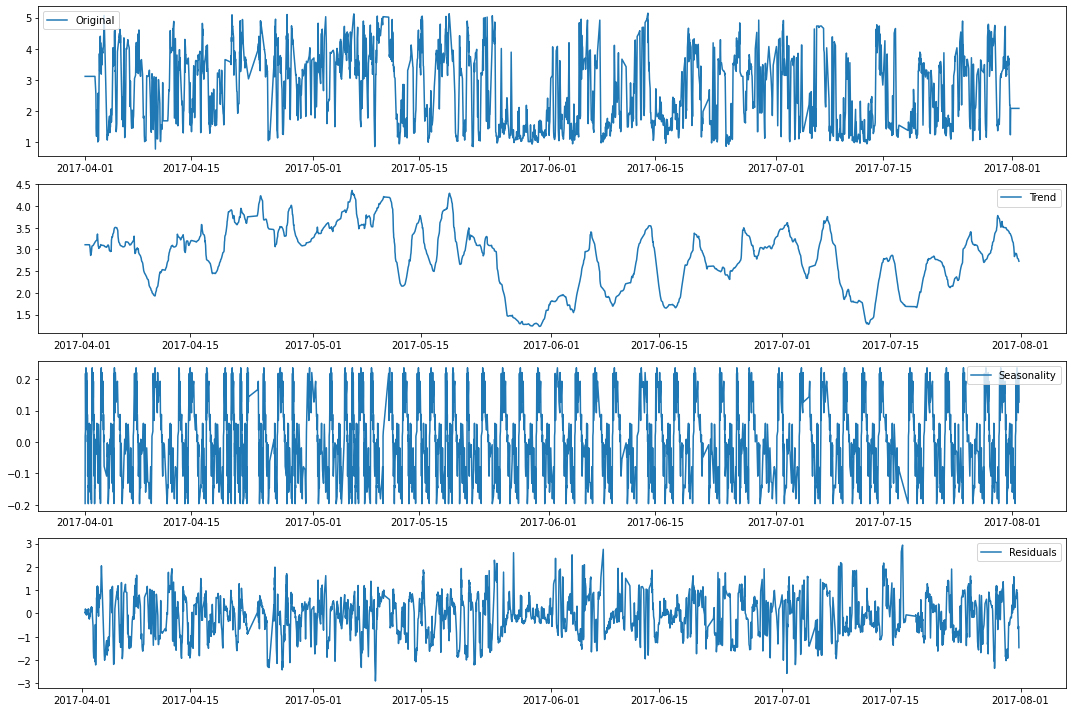

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposition(timeseries, freq):
    decomposition = seasonal_decompose(timeseries, freq=freq)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(15, 10))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

df_cut = df['2017-04-01':'2017-08-01']
decomposition(df_cut['% Silica Concentrate'], 52)
#decomposition(df['% Silica Concentrate'], 52)

The p-value represents a probability of the error when expecting, that the trend differs from zero (i.e. probability, that there is no time change and the value is based on random fluctuations only).

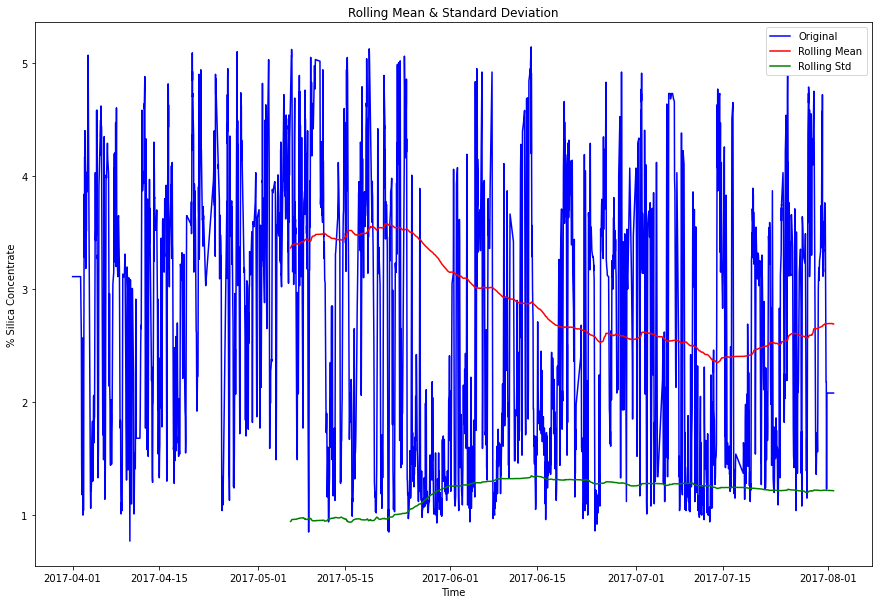

Results of Dickey-Fuller Test:
Test Statistic                -1.029997e+01
p-value                        3.392436e-18
#Lags Used                     3.000000e+00
Number of Observations Used    2.921000e+03
Critical Value (1%)           -3.432591e+00
Critical Value (5%)           -2.862530e+00
Critical Value (10%)          -2.567297e+00
dtype: float64
The timeseries is stationary at 95% level of confidence


In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(rolling).mean()
    rolstd = timeseries.rolling(rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')

    plt.xlabel('Time')
    plt.ylabel('% Silica Concentrate')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput['p-value'] < 0.05:
        print('The timeseries is stationary at 95% level of confidence')
    else:
        print('The timeseries is not stationary at 95% level of confidence')
  

test_stationarity(df_cut['% Silica Concentrate'], rolling=1000)


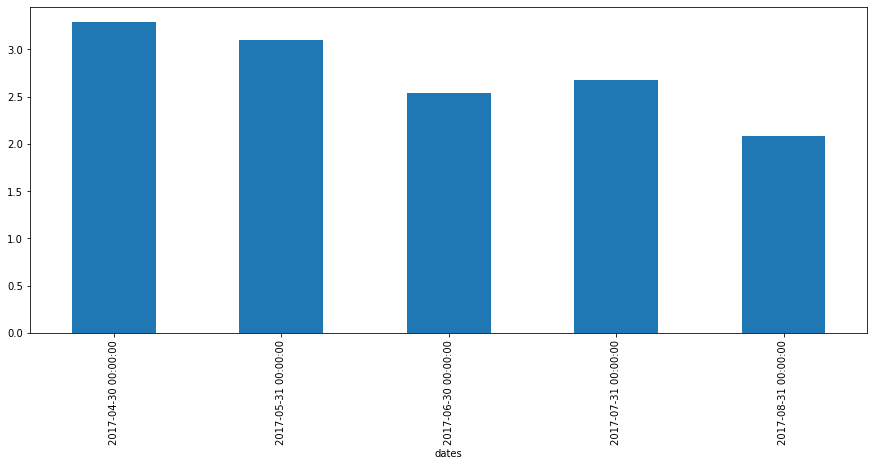

In [21]:
df_cut['% Silica Concentrate'].resample(rule='M').mean().plot(kind='bar',figsize=(15,6))

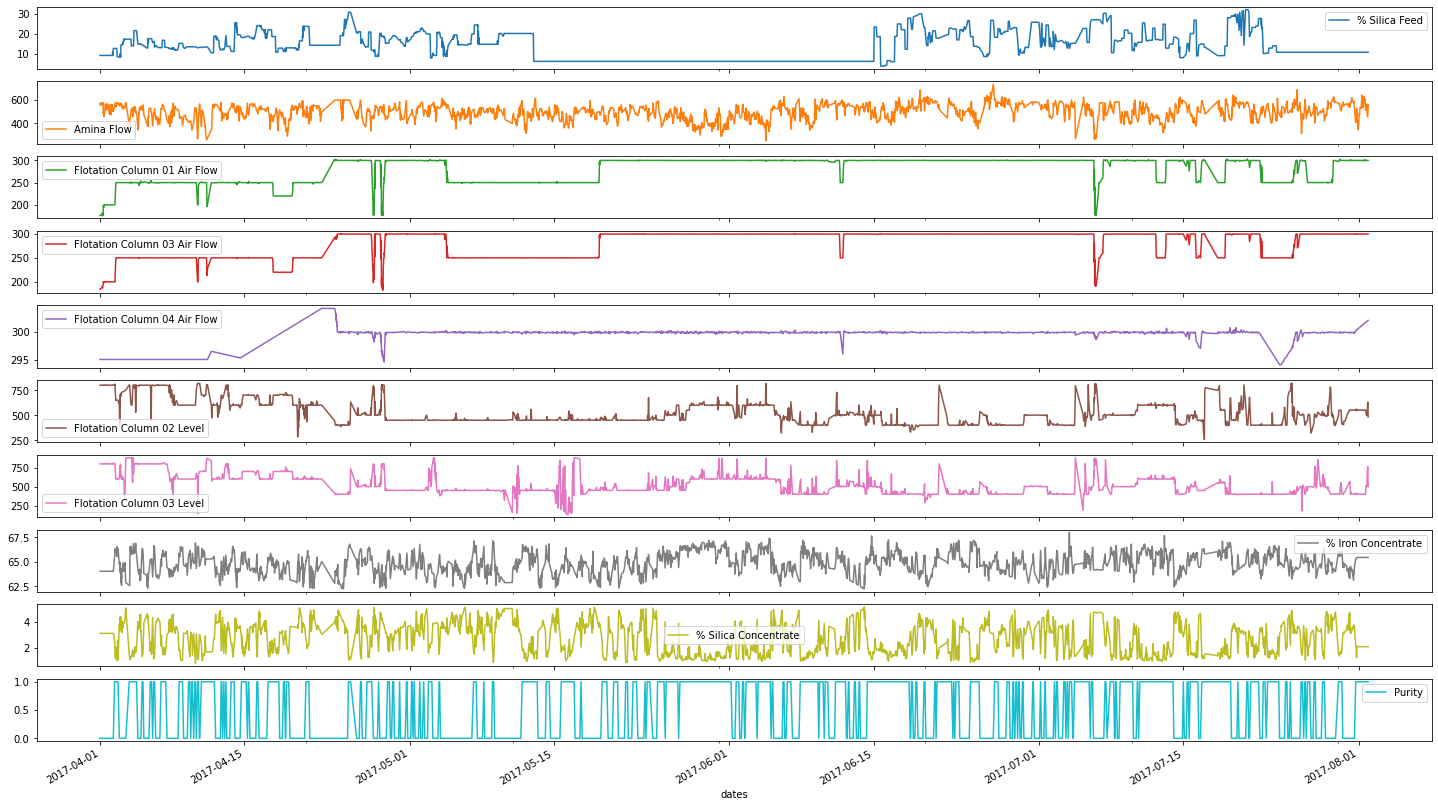

In [22]:
plot_cols = df_cut.columns
plot_features = df_cut[plot_cols]
plot_features.plot(subplots=True, figsize=(25,15));

In [ ]:
for plot_col in df.columns:
  decomposition(df[plot_col], 52)
  test_stationarity(df[plot_col], rolling=1000)

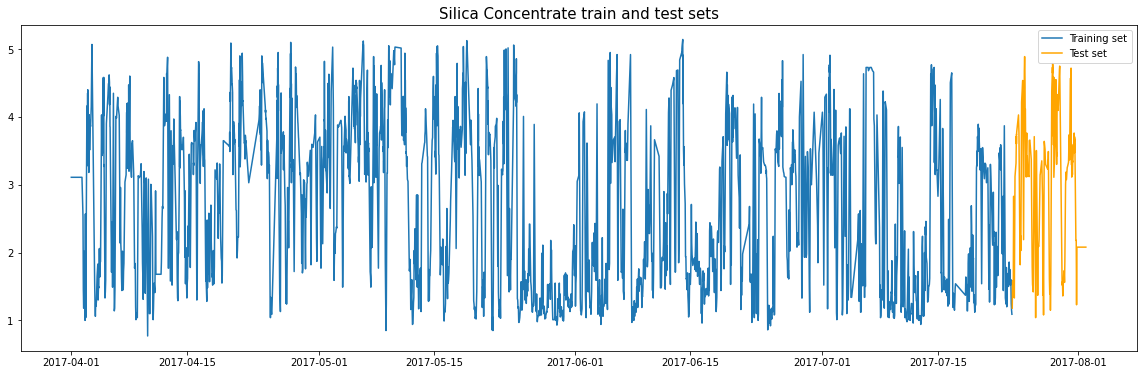

In [31]:
test_size = 200

df_train = df_cut[:-test_size]
df_test = df_cut[-test_size:]

fig, axs = plt.subplots(figsize = (20,6))

plt.title('Silica Concentrate train and test sets', size=15)
plt.plot(df_train['% Silica Concentrate'], label='Training set')
plt.plot(df_test['% Silica Concentrate'], label='Test set', color='orange')
plt.legend();